In [ ]:
pip install pycox

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pandas as pd

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [165]:
csv = pd.read_csv('/content/all-in-one.csv')
test_csv = pd.read_csv('/content/test-data.csv')

In [167]:
df_untreated_train = csv[csv.Treatment == 0]
df_treated_train = csv[csv.Treatment == 1]

In [168]:
df_untreated_test = df_untreated_train.sample(frac=0.2)
df_untreated_train = df_untreated_train.drop(df_untreated_test.index)
df_untreated_val = df_untreated_train.sample(frac=0.2)
df_untreated_train = df_untreated_train.drop(df_untreated_val.index)

df_treated_test = df_treated_train.sample(frac=0.2)
df_treated_train = df_treated_train.drop(df_treated_test.index)
df_treated_val = df_treated_train.sample(frac=0.2)
df_treated_train = df_treated_train.drop(df_treated_val.index)

In [184]:
cols_standardize = ['Var' + str(i) for i in range(1,11)]
cols_leave = ['G' + str(i) for i in range(1,301)]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [185]:
x_untreated_train = x_mapper.fit_transform(df_untreated_train).astype('float32')
x_untreated_val = x_mapper.transform(df_untreated_val).astype('float32')
x_untreated_test = x_mapper.transform(df_untreated_test).astype('float32')

x_treated_train = x_mapper.fit_transform(df_treated_train).astype('float32')
x_treated_val = x_mapper.transform(df_treated_val).astype('float32')
x_treated_test = x_mapper.transform(df_treated_test).astype('float32')

In [187]:
x_mapper_gene = [(col, None) for col in ['G' + str(i) for i in range(1,301)] +  ['Var' + str(i) for i in range(1,11)]]
x_gene = x_mapper.transform(test_csv).astype('float32')

In [92]:
print(df_treated_test)

     G1  G2  G3  G4  G5  G6  ...  Var8  Var9  Var10        time  event  Treatment
798   1   0   0   0   0   0  ...     2     1      2   39.827463      1          1
110   0   1   0   1   0   0  ...     1     0      5   69.031495      1          1
73    0   0   0   1   0   0  ...     5     1      0   37.473695      0          1
140   0   0   0   0   1   0  ...     3     3      3   39.871684      1          1
44    0   0   0   0   0   0  ...     3     0      2   41.513465      1          1
..   ..  ..  ..  ..  ..  ..  ...   ...   ...    ...         ...    ...        ...
574   1   0   0   0   0   0  ...     3     2      0   65.717296      1          1
628   0   0   0   0   0   0  ...     0     1      5   46.899993      1          1
397   0   0   0   0   0   1  ...     4     4      1  135.058491      1          1
78    0   0   0   0   0   0  ...     2     5      1   41.636496      1          1
861   0   0   0   0   0   0  ...     0     2      4   64.673073      1          1

[98 rows x 313 

In [14]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_untreated_train = get_target(df_untreated_train)
y_untreated_val = get_target(df_untreated_val)


y_treated_train = get_target(df_treated_train)
y_treated_val = get_target(df_treated_val)

untreated_durations_test, untreated_events_test = get_target(df_untreated_test)
untreated_val = x_untreated_val, y_untreated_val

treated_durations_test, treated_events_test = get_target(df_treated_test)
treated_val = x_treated_val, y_treated_val

In [15]:
in_features = x_treated_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    
    torch.nn.Linear(32, out_features)
)

In [16]:
model = CoxPH(net, tt.optim.Adam)

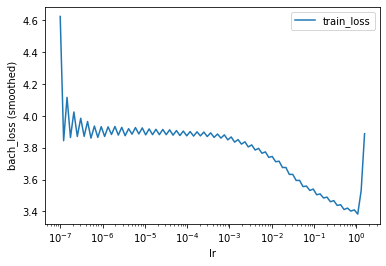

In [17]:
batch_size = 256
lrfinder = model.lr_finder(x_treated_train, y_treated_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [18]:
lrfinder.get_best_lr()

0.10722672220103299

In [19]:
model.optimizer.set_lr(0.2)

In [20]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [21]:
%%time
log = model.fit(x_treated_train, y_treated_train, batch_size, epochs, callbacks, verbose,
                val_data=treated_val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.9949,	val_loss: 7.7575
1:	[0s / 0s],		train_loss: 5.2400,	val_loss: 30.4847
2:	[0s / 0s],		train_loss: 4.4786,	val_loss: 7.7105
3:	[0s / 0s],		train_loss: 3.8097,	val_loss: 7.5903
4:	[0s / 0s],		train_loss: 3.7833,	val_loss: 4.7279
5:	[0s / 0s],		train_loss: 3.6862,	val_loss: 4.0477
6:	[0s / 0s],		train_loss: 3.6800,	val_loss: 3.6886
7:	[0s / 0s],		train_loss: 3.4598,	val_loss: 3.6670
8:	[0s / 0s],		train_loss: 3.6450,	val_loss: 3.4463
9:	[0s / 0s],		train_loss: 3.5295,	val_loss: 3.4055
10:	[0s / 0s],		train_loss: 3.5215,	val_loss: 3.3131
11:	[0s / 0s],		train_loss: 3.4843,	val_loss: 3.3735
12:	[0s / 0s],		train_loss: 3.4611,	val_loss: 3.3021
13:	[0s / 0s],		train_loss: 3.4311,	val_loss: 3.1623
14:	[0s / 0s],		train_loss: 3.4266,	val_loss: 3.1418
15:	[0s / 0s],		train_loss: 3.3262,	val_loss: 3.2725
16:	[0s / 0s],		train_loss: 3.1598,	val_loss: 3.4215
17:	[0s / 0s],		train_loss: 3.3036,	val_loss: 3.1437
18:	[0s / 0s],		train_loss: 3.1669,	val_loss: 3.0019
19

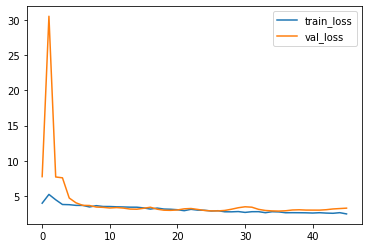

In [22]:
_ = log.plot()

In [52]:
_ = model.compute_baseline_hazards()

In [ ]:
model.baseline_hazards_.to_list()

In [192]:
surv = model.predict_surv_df(x_gene)

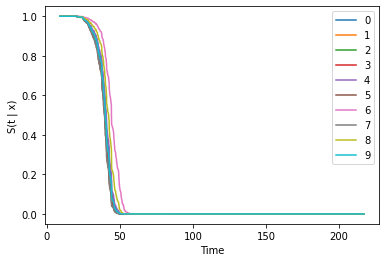

In [200]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')